# Data Augmentation

In [2]:
import numpy as np
from torchvision import transforms
from torch import optim
from torch.nn import functional as F
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import utils

## torchvision.transforms

torchvision.transformsを使用

1. transforms.Composeクラスにさまざまなtransformのインスタンスのリストを
渡す
    - https://pytorch.org/vision/0.15/transforms.html
    - RandomHorizontalFlip: ランダムに画像を水平反転
    - RandomCrop: ランダムに画像を切り抜く
    - RandomRotaton: ランダムに画像を回転
2. Datasetクラスのtransform引数に，transforms.Composeのインスタンスを指 定する

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = CIFAR10('./cifar10_data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

100%|██████████| 170498071/170498071 [00:44<00:00, 3864323.17it/s]


Extracting ./cifar10_data/cifar-10-python.tar.gz to ./cifar10_data


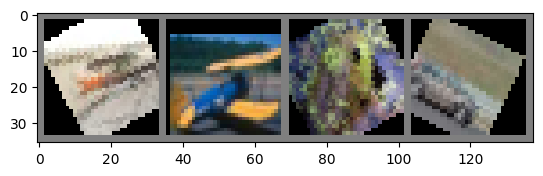

In [4]:
X, y = next(iter(train_loader))
X = make_grid(X).permute(1, 2, 0)
X = X / 2 + 0.5
plt.imshow(X)

## Albumentations

1. albumenta+ons.Composeに，albumenta+ons.に続くクラスのインスタンスのリストを入れる
2. tensorへの変換はalbumenta+ons.pytorch.ToTensorV2を使用する
3. wrapperクラスを作成
    - transformを引数にとる
    - __call__メソッドを作成し，transformを適用し画像とラベル(ラベルがない場合は画像のみ)を返す
    - albumenta+ons.Composeのインスタンスをcallする時にはnumpy arrayを引数とし，結果は[’image’]でアクセスする
4. Datasetクラスのtransform引数にwrapperクラスのインスタンスを渡す

In [3]:
# 以下はOpenCVインストールに必要なコマンド
# !pip install albumentations
# !pip install opencv-python
#$sudo apt-get update
#$sudo apt-get install libgll-mesa-glx
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [4]:
transform = A.Compose([
    A.HorizontalFlip(),
    A.PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_CONSTANT),
    A.RandomCrop(height=32, width=32),
    A.Rotate(limit=30, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ToTensorV2(),
])

In [5]:
class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, image, target=None):
        image = self.transform(image=np.array(image))['image']
        if target:
            return image, target
        else:
            return image

In [6]:
transform = AlbumentationsTransform(transform)
train_dataset = CIFAR10('./cifar10_data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)

Files already downloaded and verified


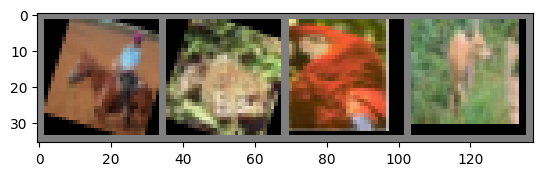

In [7]:
X, y = next(iter(train_loader))
X = make_grid(X).permute(1, 2, 0)
X = X / 2 + 0.5
plt.imshow(X)

## imgaug

1. imgaug.augmenters.Sequen+al()にimgaug.augmenters.に続くaugmenta+on用のク ラスのインスタンスのリストを渡しインスタンス作成
2. wrapperクラスを作成
    - imgaug.augmenters.Sequen+al()のインスタンスを受け取り，インスタンス変数にする
    - __call__メソッドを作成， imgaug.augmenters.Sequen+alのインスタンスに対して.augment_imageを実行し返す(引数にはnumpyを使用)
3. torchvision.transforms.Composeの引数のリストにwrapperクラスのインスタンスを入れる
4. Datasetのtransformに, torchvision.transforms.Composeのインスタンスを渡す

In [8]:
# !pip install imgaug
from imgaug import augmenters as iaa
import imgaug as ia

In [9]:
transform_ia_seq = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Pad(px=4),
    iaa.CropToFixedSize(width=32, height=32),
    iaa.Affine(rotate=(-30, 30))
])

class ImgAugTransform:
    def __init__(self, ia_seq):
        self.ia_seq = ia_seq

    def __call__(self, image, target=None):
        image = self.ia_seq.augment_image(np.array(image))
        if target:
            return image, target
        else:
            return image

Files already downloaded and verified


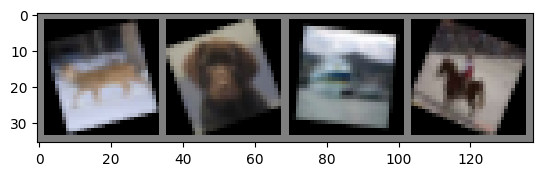

In [10]:
transform_ia = ImgAugTransform(transform_ia_seq)
transform = transforms.Compose([
    transform_ia,
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_dataset = CIFAR10('./cifar10_data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
X, y = next(iter(train_loader))
X = make_grid(X).permute(1, 2, 0)
X = X / 2 + 0.5
plt.imshow(X)

## DataAugmentationで学習

どのライブラリを選択するか?
- チームで普段使っているものがあればそれを使う，そうでなければそれぞれの 特徴を理解してやりたいことが実現できるライブラリを選択する
- Pytorch:
    - ○Pytorchとの統合が容易で簡単に始められる
    - ×機能が限られる
- Albumenta+ons:
    - ○高速で拡張機能が多様
    - ○様々なデータタイプに統一的なAPIを提供
    - ×APIが少し複雑
- imgaug:
    - ○豊富なAugmenta+on • ×場合によっては低速

In [11]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = CIFAR10('./cifar10_data', train=True, download=True, transform=transform)
val_dataset = CIFAR10('./cifar10_data', train=False, download=True, transform=transform_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=6)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
conv_model = utils.get_conv_model(in_ch=3)
opt = optim.Adam(conv_model.parameters(), lr=0.03)
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, 5)

epoch: 0: train error: 1.7749503222877716, validation error: 1.5948650369161292, validation accuracy: 0.4182159810126582


epoch: 1: train error: 1.6002623620240584, validation error: 1.5680880259863939, validation accuracy: 0.4442246835443038


epoch: 2: train error: 1.5422998959451075, validation error: 1.4450445160081116, validation accuracy: 0.473496835443038


epoch: 3: train error: 1.516715958295271, validation error: 1.4609673521186732, validation accuracy: 0.46825553797468356


epoch: 4: train error: 1.4966478469731557, validation error: 1.3740788713286194, validation accuracy: 0.5019778481012658


In [13]:
train_dataset_no_aug = CIFAR10('./cifar10_data', train=True, download=True, transform=transform_val)
train_loader_no_aug = DataLoader(train_dataset_no_aug, batch_size=128, shuffle=True, num_workers=4)
conv_model_no_aug = utils.get_conv_model(in_ch=3)
opt_no_aug = optim.Adam(conv_model_no_aug.parameters(), lr=0.03)
train_losses, val_losses, val_accuracies = utils.learn(conv_model_no_aug, train_loader_no_aug, val_loader, opt_no_aug, F.cross_entropy, 5)

Files already downloaded and verified


epoch: 0: train error: 1.6029438932838342, validation error: 1.4540421660942366, validation accuracy: 0.4653876582278481


epoch: 1: train error: 1.388188616698965, validation error: 1.4675746507282499, validation accuracy: 0.47972705696202533


epoch: 2: train error: 1.3164698385521578, validation error: 1.3176775627498385, validation accuracy: 0.5225474683544303


epoch: 3: train error: 1.274949569226531, validation error: 1.3438881952551347, validation accuracy: 0.5188884493670886


epoch: 4: train error: 1.2460994976560782, validation error: 1.295781425282925, validation accuracy: 0.5349090189873418
